In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch as th
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as transforms
import pickle as pkl
import sys
torch.cuda.empty_cache()
sys.path.append('/content/drive/MyDrive/CID/')
sys.path.append('/content/drive/MyDrive/CID/data/')
sys.path.append('/content/drive/MyDrive/CID/networks/')

In [3]:
path='/content/drive/MyDrive/CID/data/'
params = dict()
params['DATA_DIR']=path+'/data.pkl'
params['IMG_DIR'] = path+'data/images' 
params['WORKERS']=2
params['IMSIZE']=32
params['BATCH_SIZE']=128

In [4]:
import pickle

def save_pickle(obj, file_name):
    """
    save the given data obj as a pickle file
    :param obj: python data object
    :param file_name: path of the output file
    :return: None (writes file to disk)
    """
    with open(file_name, 'wb') as dumper:
        pickle.dump(obj, dumper, pickle.HIGHEST_PROTOCOL)

def load_pickle(file_name):
    """
    load a pickle object from the given pickle file
    :param file_name: path to the pickle file
    :return: obj => read pickle object
    """
    with open(file_name, "rb") as pick:
        obj = pickle.load(pick)

    return obj

In [5]:
from torch.utils.data import Dataset
import os
import PIL

class Text2FaceDataset(Dataset):
    """ PyTorch Dataset wrapper around the Face2Text dataset """

    def __load_data(self,path):
        """
        private helper for loading the data
        :return: data => dict of data objs
        """
        data = load_pickle(path)

        return data

    def __init__(self, desc_path, img_path, img_transform=None):
        """
        constructor of the class
        :param desc_path: path to image description directory
        :param img_path: path to the images directory
        :param img_transform: torch_vision transform to apply
        """

        # create state:
        self.transform = img_transform
        
        # create data object
        self.img_path=img_path
        self.data_obj = self.__load_data(desc_path)

        # extract all the data
        self.encoded_data = self.data_obj['captions']
        self.images = self.data_obj['images']


    def __len__(self):
        """
        obtain the length of the data-items
        :return: len => length
        """
        return len(self.images)

    def __getitem__(self, ix):
        """
        code to obtain a specific item at the given index
        :param ix: index for element query
        :return: (caption, img) => caption and the image
        """

        # read the image at the given index
        img_file_path = os.path.join(self.img_path, self.images[ix])
        img = PIL.Image.open(img_file_path)

        # transform the image if required
        if self.transform is not None:
            img = self.transform(img)

        # get the encoded caption:
        caption = self.encoded_data[ix]

        # return the data element
        return caption, img

def get_transform(new_size=None):
    """
    obtain the image transforms required for the input data
    :param new_size: size of the resized images
    :return: image_transform => transform object from TorchVision
    """
    from torchvision.transforms import ToTensor, Normalize, Compose, Resize

    if new_size is not None:
        image_transform = Compose([
            Resize(new_size),
            ToTensor(),
            Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
        ])

    else:
        image_transform = transforms.Compose([
            ToTensor(),
            Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
        ])
    return image_transform


def get_data_loader(dataset, train_sampler, batch_size, num_workers):
    """
    generate the data_loader from the given dataset
    :param dataset: F2T dataset
    :param batch_size: batch size of the data
    :param num_workers: num of parallel readers
    :return: dl => dataloader for the dataset
    """
    from torch.utils.data import DataLoader
    if train_sampler:
      dl = DataLoader(
          dataset,
          batch_size=batch_size,
          sampler=train_sampler,
          num_workers=num_workers,
          drop_last=True
      )
    else:
      dl = DataLoader(
          dataset,
          shuffle=True,
          batch_size=batch_size,
          num_workers=num_workers,
      )
    return dl

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

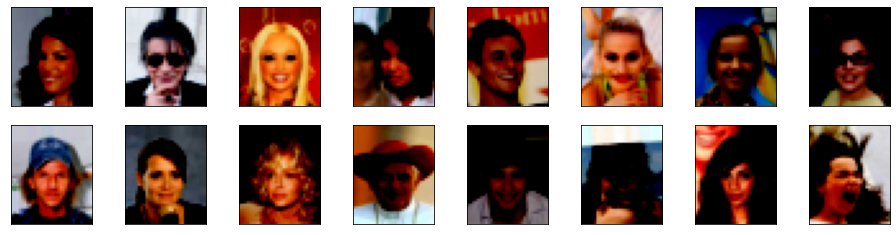

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
path='/content/drive/MyDrive/CID/data'
data_loader=get_data_loader(Text2FaceDataset(path+'/emd.pkl',path+'/data/images',img_transform=get_transform(params['IMSIZE'])),False,params['BATCH_SIZE'],params['WORKERS'])

# helper display function
def imshow(img):
    img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(data_loader)
d,images= dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(16, 4))
plot_size=16
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

In [6]:
import torch
from torchvision import transforms
from torchvision.utils import make_grid

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import numpy as np
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt

In [7]:
CUDA = False
cond_dim = 64
df_dim = 32
gf_dim = 32
z_dim = 50
emb_dim = 256

In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [9]:
def Conv_k3(in_p, out_p, stride=1):
    return nn.Conv2d(in_p, out_p, kernel_size=3, stride=stride, padding=1, bias=False)

class Upblock(nn.Module):
    def __init__(self, inp, outp):
        super(Upblock, self).__init__()
        self.up = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv = Conv_k3(inp, outp)
        self.batch = nn.BatchNorm2d(outp)
        self.relu = nn.ReLU(True)
        self.drop_out = nn.Dropout(0.2)
        
    def forward(self, x):
        o = self.up(x)
        o = self.relu(self.conv(o))
        o = self.batch(o)
        return o

In [10]:
class D_output(nn.Module):
    def __init__(self, have_cond = True):
        super(D_output, self).__init__()
        self.have_cond = have_cond
        self.classifier = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )
        if have_cond:
            cond_part = nn.Sequential(
                Conv_k3(in_p=256+cond_dim, out_p=512),
                nn.BatchNorm2d(512),
                nn.LeakyReLU(0.2, inplace=True),
            )
            self.classifier = torch.nn.Sequential(*(list(cond_part)+list(self.classifier)))
        print(self.classifier)
            
    def forward(self, encoded_image, encoded_cond=None):
        if self.have_cond and encoded_cond is not None:
            cond = encoded_cond.view(-1, cond_dim , 1, 1)
            cond = cond.repeat(1, 1, 2, 2)
            image_with_cond = torch.cat((encoded_image, cond), 1)
        else:
            image_with_cond = encoded_image
        return self.classifier(image_with_cond).view(-1)

In [11]:
class CondAugment_Model(nn.Module):
    def __init__(self):
        super(CondAugment_Model,self).__init__()
        self.fc = nn.Linear(in_features=emb_dim, out_features=cond_dim*2,bias=True)
        self.relu = nn.ReLU(True)
        
    def convert(self, embed):
        x = self.relu(self.fc(embed))
        mean, sigma = x[:, : cond_dim], x[:, cond_dim:]
        return mean, sigma
    
    def forward(self, x):
        mean, sigma = self.convert(x)
        diag = torch.exp(sigma*0.5)
        if CUDA:
            normal_dis = (torch.FloatTensor(diag.size()).normal_()).cuda()
        else:
            normal_dis = (torch.FloatTensor(diag.size()).normal_())
        condition = (diag*normal_dis)+mean
        return condition, mean, sigma

In [12]:
class G_Stage1(nn.Module):
    def __init__(self):
        super(G_Stage1, self).__init__()
        self.CA = CondAugment_Model()
        self.fc = nn.Sequential(
            nn.Linear(in_features=114, out_features=gf_dim*8*2*2, bias=False),
            nn.BatchNorm1d(gf_dim*8*2*2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2)
        )
        self.img = nn.Sequential(
            Upblock(gf_dim*8,gf_dim*4),
            Upblock(gf_dim*4,gf_dim*2),
            Upblock(gf_dim*2,gf_dim),
            Upblock(gf_dim,16),
            Conv_k3(16, 3),
            nn.Tanh()
        )
        
    def forward(self, noise, emb):
        cond, mean, sigma = self.CA(emb)
        cond = cond.view(noise.size(0), cond_dim, 1, 1)
        x = torch.cat((noise, cond),1)
        x = x.view(-1, 114) # z_dim + cond_dim
        o = self.fc(x)
        h_code = o.view(-1, gf_dim*8, 2, 2)
        fake_img = self.img(h_code)
        return fake_img, mean, sigma

In [13]:
class D_Stage1(nn.Module):
    def __init__(self):
        super(D_Stage1, self).__init__()
        self.encoder = nn.Sequential(
            #c alucalation output size = [(input_size −Kernal +2Padding )/Stride ]+1
            # input is image 3 x 32 x 32  
            nn.Conv2d(in_channels=3, out_channels=df_dim, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),# => 32 x 16 x 16
            
            nn.Conv2d(in_channels=df_dim, out_channels=df_dim*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(df_dim*2),
            nn.LeakyReLU(0.2, inplace=True),# => 64 x 8 x 8
            
            nn.Conv2d(in_channels=df_dim*2, out_channels=df_dim*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(df_dim*4),
            nn.LeakyReLU(0.2, inplace=True),# => 128 x 4 x 4
            
            nn.Conv2d(in_channels=df_dim*4, out_channels=df_dim*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(df_dim*8),
            nn.LeakyReLU(0.2, inplace=True),# => 512 x 2 x 2
        )
        self.condition_classifier = D_output()
        self.uncondition_classifier = None
        
    def forward(self, image):
        return self.encoder(image)

In [14]:
def KL_loss(mean, sigma):
    #loss = nn.KLDivLoss()
    KLD_element = mean.pow(2).add_(sigma.exp()).mul_(-1).add_(1).add_(sigma)
    KLD = torch.mean(KLD_element).mul_(-0.5)
    #return loss(mean,sigma)
    return KLD

In [15]:
def cal_G_loss(netD, fake_imgs, real_labels, cond):
    criterion = nn.BCELoss()
    cond = cond.detach()
    fake_f = netD(fake_imgs)

    fake_cond_ouput = netD.condition_classifier(fake_f, cond)
    errD_fake = criterion(fake_cond_ouput, real_labels)
    if netD.uncondition_classifier is not None:
        fake_uncond_output = netD.uncondition_classifier(fake_f)
        uncond_errD_fake = criterion(fake_uncond_output, real_labels)
        errD_fake += uncond_errD_fake
    return errD_fake

In [16]:
def cal_D_loss(netD, real_imgs, fake_imgs, real_labels, fake_labels, cond):
    criterion = nn.BCELoss()
    batch_size = real_imgs.size(0)
    cond = cond.detach()
    fake = fake_imgs.detach()

    real_img_feature = netD(real_imgs)
    fake_img_feature = netD(fake)

    real_output = netD.condition_classifier(real_img_feature, cond)
    errD_real  = criterion(real_output, real_labels)
    wrong_output = netD.condition_classifier(real_img_feature[:(batch_size-1)], cond[1:])
    errD_wrong = criterion(wrong_output, fake_labels[1:])

    fake_output = netD.condition_classifier(fake_img_feature, cond)
    errD_fake= criterion(fake_output, fake_labels)

    if netD.uncondition_classifier is not None:
        real_uncond_output = netD.uncondition_classifier(real_img_feature)
        errD_real_uncond = criterion(real_uncond_output, real_labels)

        fake_uncond_output = netD.uncondition_classifier(fake_img_feature)
        errD_fake_uncond = criterion(fake_uncond_output, fake_labels)

        errD = (errD_real+errD_real_uncond)/2. + (errD_fake+errD_wrong+errD_fake_uncond)/3.
        errD_real =  (errD_real+errD_real_uncond)/2
        errD_fake = (errD_fake+errD_fake_uncond)/2.
    else:
        errD = errD_real + (errD_fake+errD_wrong)*0.5
    return errD, errD_real.item(), errD_wrong.item(), errD_fake.item()

In [17]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    return x * (max - min) + min

def save_model(netG, netD, epoch, model_dir):
    torch.save(
        netG.state_dict(),
        '%s/netG_epoch_%d.pth' % (model_dir, epoch))
    torch.save(
        netD.state_dict(),
        '%s/netD_epoch_last.pth' % (model_dir))
    print('Save G/D models')

In [19]:
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8-cp37-cp37m-linux_x86_64.whl

     |████████████████████████████████| 144.6MB 76kB/s 
     |████████████████████████████████| 61kB 3.4MB/s 
ERROR: earthengine-api 0.1.260 has requirement google-api-python-client<2,>=1.12.1, but you'll have google-api-python-client 1.8.0 which is incompatible.
  Found existing installation: google-api-python-client 1.12.8
    Uninstalling google-api-python-client-1.12.8:
      Successfully uninstalled google-api-python-client-1.12.8


In [20]:
import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.utils.serialization as xser

In [ ]:
import torch
import torch_xla
import torch_xla.core.xla_model as xm
import warnings

warnings.filterwarnings("ignore")
torch.manual_seed(42)
torch.set_default_tensor_type('torch.FloatTensor')

In [22]:
model_path= "/content/drive/MyDrive/CID/models"
losses=[]

In [23]:
# training

def main():
    device = 'cuda' if torch.cuda.is_available() else xm.xla_device()
    transform = transforms.Compose([
                transforms.Resize(32),
                transforms.RandomCrop(32),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                ])
    
    dataset= Text2FaceDataset(path+'/emd.pkl',path+'/data/images',img_transform=transform)
    data_loader=get_data_loader(dataset,False,params['BATCH_SIZE'],params['WORKERS'])

    netD = D_Stage1().to(device)
    netG = G_Stage1().to(device)
  
    netG.apply(weights_init)
    netD.apply(weights_init)
    
    netD.load_state_dict(torch.load(model_path+'/stage1/netD1_epoch_last.pth',map_location=torch.device('cpu')))
    netG.load_state_dict(torch.load(model_path+'/stage1/netG1_epoch_last.pth',map_location=torch.device('cpu')))
    netD.train()
    netG.train()
    lr = 0.0002
    
    optD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999), eps=0.00000001)
    optG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999), eps=0.00000001)
    
    for epochs in [160,80,40,20,10]:
      iters = 0
      samples=[]
      num_epoch = epochs
      for epoch in range(1,num_epoch+1):
          if epoch % 100 == 0 and epoch > 0:
              lr = lr*0.5
              for param_group in optG.param_groups:
                  param_group['lr'] = lr
              for param_group in optD.param_groups:
                  param_group['lr'] = lr
          
          for i, data in enumerate(data_loader,0):
              encoded_caps,real_imgs = data
              batch_size = encoded_caps.size(0)
              real_imgs = scale(real_imgs.to(device))
              encoded_caps = encoded_caps.to(device) 
              fixed_noise = torch.FloatTensor(batch_size, z_dim, 1, 1).normal_(0, 1).to(device)
              real_labels = (torch.FloatTensor(batch_size).fill_(1)).to(device)
              fake_labels = (torch.FloatTensor(batch_size).fill_(0)).to(device)

              ##update discriminator
              netD.zero_grad()
              # generate fake image
              noise = torch.FloatTensor(batch_size, z_dim, 1, 1).normal_(0, 1).to(device)
              fake_imgs, m, s = netG(noise, encoded_caps)
              errD, errD_real, errD_wrong, errD_fake = cal_D_loss(netD, real_imgs, fake_imgs, real_labels, fake_labels, m)
              errD.backward()
              optD.step()
              if not CUDA:
                xm.mark_step()

              ##update generator
              netG.zero_grad()
              errG = cal_G_loss(netD, fake_imgs, real_labels, m)+ KL_loss(m, s)
              errG.backward()
              optG.step()
              if not CUDA:
                xm.mark_step()
              
              if i%50 == 0:
                  losses.append((errD.item(), errG.item()))
                  print('[%d/%d][%d/%d]\tLoss_D: %.4f Loss_G: %.4f Loss_D_R: %.4f Loss_D_W: %.4f Loss_D_F %.4f'
                        % (epoch, num_epoch, i, len(data_loader),
                          errD.item(), errG.item(), errD_real, errD_wrong, errD_fake))
            
              if epoch%10 == 0:
                  with torch.no_grad():
                      fake,_,_ = netG(fixed_noise, encoded_caps)
                      fig = plt.figure(figsize=(8,8))
                      grid = make_grid(fake.detach().cpu(), nrow=8, normalize=True).permute(1,2,0).numpy()
                      samples.append(grid)
                      plt.imshow(grid)
                      
                  with open(model_path+'/results/train_samples_1.pkl', 'wb') as f:
                                pkl.dump(samples, f)
          if CUDA:
            torch.save(netG.state_dict(), model_path+'/stage1/netG1_epoch_last.pth')
            torch.save(netD.state_dict(), model_path+'/stage1/netD1_epoch_last.pth')
          else:
            xm.save(netG.state_dict(), model_path+'/stage1/netG1_epoch_last.pth')
            xm.save(netD.state_dict(), model_path+'/stage1/netD1_epoch_last.pth') 

if __name__ == '__main__':
      main()

"\ndef main():\n    device = 'cuda' if torch.cuda.is_available() else xm.xla_device()\n    transform = transforms.Compose([\n                transforms.Resize(32),\n                transforms.RandomCrop(32),\n                transforms.RandomHorizontalFlip(),\n                transforms.ToTensor(),\n                ])\n    \n    dataset= Text2FaceDataset(path+'/emd.pkl',path+'/data/images',img_transform=transform)\n    data_loader=get_data_loader(dataset,False,params['BATCH_SIZE'],params['WORKERS'])\n\n    netD = D_Stage1().to(device)\n    netG = G_Stage1().to(device)\n  \n    netG.apply(weights_init)\n    netD.apply(weights_init)\n    \n    netD.load_state_dict(torch.load(model_path+'/stage1/netD1_epoch_last.pth',map_location=torch.device('cpu')))\n    netG.load_state_dict(torch.load(model_path+'/stage1/netG1_epoch_last.pth',map_location=torch.device('cpu')))\n    netD.train()\n    netG.train()\n    lr = 0.0002\n    \n    optD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999),

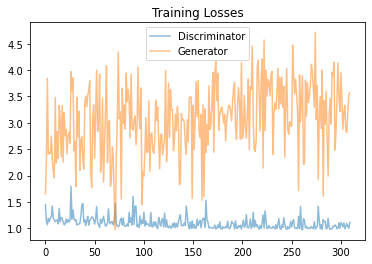

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [ ]:
path="/content/drive/MyDrive/CID/data/"
data = load_pickle(path+"data.pkl")
desc = data["desc"][0:63]

from textEncoder import PretrainedEncoder
from embgen import Embedder

device = 'cuda' if torch.cuda.is_available() else 'cpu'
pretrained_encoder_file= "/content/drive/MyDrive/CID/networks/InferSent/models/infersent2.pkl"
pretrained_embedding_file= "/content/drive/MyDrive/CID/networks/InferSent/models/glove.840B.300d.txt"

text_encoder = PretrainedEncoder(
                model_file=pretrained_encoder_file,
                embedding_file=pretrained_embedding_file,
                device=device
            )

embedder = Embedder(
                  embedding_size=4096,
                  hidden_size=256,
                  num_layers=1
              )

text_encoder.eval()
embedder = embedder.to(device) 
embedder.eval()

Vocab size : 300000


Embedder(
  (network): Sequential(
    (0): LSTM(4096, 256, batch_first=True)
  )
)

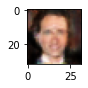

In [ ]:
# testing

def main():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    #print("Process", index ,"is using", xm.xla_real_devices([str(device)])[0])
      
    batch_size = params["BATCH_SIZE"]
    transform = transforms.Compose([
                transforms.Resize(32),
                transforms.RandomCrop(32),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                ])
    
    dataset= Text2FaceDataset(path+'/emd.pkl',path+'/data/images',img_transform=transform)
    data_loader=get_data_loader(dataset,False,params['BATCH_SIZE'],params['WORKERS'])

    netG = G_Stage1().to(device)
    netG.apply(weights_init)
    netG.load_state_dict(torch.load(model_path+'/stage1/netG1_epoch_last.pth',map_location=torch.device('cpu')))
    netG.eval()

    num_epoch = 1
    iters = 0
    samples=[]
    for epoch in range(1,num_epoch+1):
        for i, data in enumerate(data_loader,0):
            encoded_caps,real_imgs = data
            batch_size = encoded_caps.size(0)
            real_imgs = scale(real_imgs.to(device))
            encoded_caps = encoded_caps.to(device) 
            fixed_noise = torch.FloatTensor(1, z_dim, 1, 1).normal_(0, 1).to(device)

            if i%1==0:
                with torch.no_grad():
                    sample_input ="""female happy face, long white curly hair"""
                    input = [sample_input]
                    encoding = text_encoder(input)
                    encoding = encoding.reshape((1,encoding.shape[0], encoding.shape[1]))
                    embedding = embedder(torch.from_numpy(encoding).float().to(device))
                    encoded_caps = embedding.to(device)[0]
                    fake,_,_ = netG(fixed_noise, encoded_caps)
                    fig = plt.figure(figsize=(1,1))
                    grid = make_grid(fake.detach().cpu(), nrow=8, normalize=True).permute(1,2,0).numpy()
                    samples.append(grid)
                    plt.imshow(grid)
            
            break     
        #with open(model_path+'/results/test_samples_1.pkl', 'wb') as f:
        #                     pkl.dump(samples, f)
    

if __name__ == '__main__':
      main()

In [ ]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    #fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for img in samples[:-1]:
        #ax.xaxis.set_visible(False)
        #ax.yaxis.set_visible(False)
        plt.imshow(img)

In [ ]:
model_path='/content/drive/MyDrive/CID/models'
# Load samples from generator, taken while training
with open('/content/drive/MyDrive/CID/models/results/train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

In [ ]:
view_samples(-1, samples)